**Student Name:** Tahir Ahmed  
**PRN:** 230200041  
**Program:** 3rd Year – SCDS  
**Faculty Guide:** Dr. Ramprasad Krishnamoorthy


# Transformer Encoder–Based Text Classification on the Reuters Dataset

**Course:** Deep Learning (CDS301)

## Objective
This project investigates the use of Transformer encoder architectures for multi-class text classification using the Reuters dataset.  
The impact of Transformer depth is studied by varying the number of encoder blocks and comparing performance against baseline models implemented in Assignment-1.



###  Dataset Description

The Reuters dataset contains short newswire articles published in 1986, each labeled with one of 46 topic categories.  
It is a standard benchmark dataset for multi-class text classification and is suitable for evaluating sequence models and attention-based architectures.


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


### Data Preprocessing

All text sequences are truncated or padded to a fixed length.  
A fixed vocabulary size is used to ensure consistency across experiments.


In [13]:
# Hyperparameters (as specified in the project prompt)
vocab_size = 10000
maxlen = 200
num_classes = 46
embed_dim = 32
num_heads = 4
ff_dim1 = 32
ff_dim2 = 64

# Load dataset
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=vocab_size)

# Pad sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


### Transformer Encoder Architecture

Only the encoder component of the Transformer architecture is used, since text classification does not require sequence generation.  
Each encoder block consists of:
- Multi-head self-attention
- A position-wise feed-forward network
- Residual connections and layer normalization


In [14]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(maxlen, embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1])
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [15]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.ln1 = layers.LayerNormalization()
        self.ln2 = layers.LayerNormalization()

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.ln1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.ln2(out1 + ffn_output)


### Transformer Model Construction

The number of encoder blocks is controlled using the variable `num_transformer_layers`.  
The first and last encoder blocks use a feed-forward dimension of 32, while intermediate blocks use a higher dimension of 64.  
Intermediate blocks are added iteratively as required.


In [16]:
def build_transformer_model(num_transformer_layers):
    inputs = layers.Input(shape=(maxlen,))
    x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)

    # First encoder block
    x = TransformerBlock(embed_dim, num_heads, ff_dim1)(x)

    # Intermediate encoder blocks (iterative)
    for _ in range(num_transformer_layers - 2):
        x = TransformerBlock(embed_dim, num_heads, ff_dim2)(x)

    # Last encoder block
    x = TransformerBlock(embed_dim, num_heads, ff_dim1)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)


### Experiments and Results

To study the effect of Transformer depth, three controlled experiments are conducted by varying the number of encoder blocks while keeping all other hyperparameters constant.

- **Experiment 1:** Transformer with 3 encoder blocks  
- **Experiment 2:** Transformer with 5 encoder blocks  
- **Experiment 3:** Transformer with 7 encoder blocks  

Each model is trained for 10 epochs using the Adam optimizer and evaluated using Macro F1-score.



In [17]:
#Experiment 1: Transformer with 3 Encoder Blocks
model_3 = build_transformer_model(3)
model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_3.fit(
    x_train, y_train_cat,
    epochs=10,
    batch_size=32,
    verbose=1
)

f1_3 = compute_macro_f1(model_3)
print("Macro F1-score (3 layers):", f1_3)



Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4901 - loss: 2.0940
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8033 - loss: 0.8709
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8914 - loss: 0.4982
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9256 - loss: 0.3469
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9508 - loss: 0.2163
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9528 - loss: 0.1718
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9588 - loss: 0.1404
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9603 - loss: 0.1234
Epoch 9/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9626 - loss: 0.1104
Epoch 10/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9574 - loss: 0.1125
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
Macro F1-score (3 layers): 0.5753075776627198


In [18]:
#Experiment 2: Transformer with 5 Encoder Blocks
model_5 = build_transformer_model(5)
model_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_5.fit(
    x_train, y_train_cat,
    epochs=10,
    batch_size=32,
    verbose=1
)

f1_5 = compute_macro_f1(model_5)
print("Macro F1-score (5 layers):", f1_5)



Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.4826 - loss: 2.1101
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7230 - loss: 1.1171
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8132 - loss: 0.7627
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8698 - loss: 0.5700
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9065 - loss: 0.4189
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9239 - loss: 0.3346
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9459 - loss: 0.2423
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9441 - loss: 0.2369
Epoch 9/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9505 - loss: 0.1992
Epoch 10/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9507 - loss: 0.1773
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
Macro F1-score (5 layers): 0.5349832951749303


In [19]:
#Experiment 3: Transformer with 7 Encoder Blocks
model_7 = build_transformer_model(7)
model_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_7.fit(
    x_train, y_train_cat,
    epochs=10,
    batch_size=32,
    verbose=1
)

f1_7 = compute_macro_f1(model_7)
print("Macro F1-score (7 layers):", f1_7)



Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.4338 - loss: 2.2371
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.6926 - loss: 1.2869
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7750 - loss: 0.9288
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8374 - loss: 0.6751
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8782 - loss: 0.5234
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9046 - loss: 0.4220
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9241 - loss: 0.3397
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9280 - loss: 0.3153
Epoch 9/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9353 - loss: 0.2843
Epoch 10/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9421 - loss: 0.2376
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
Macro F1-score (7 layers): 0.5002524320084687


In [20]:
transformer_f1_scores = {
    "Transformer-3": f1_3,
    "Transformer-5": f1_5,
    "Transformer-7": f1_7
}

transformer_f1_scores


{'Transformer-3': 0.5753075776627198,
 'Transformer-5': 0.5349832951749303,
 'Transformer-7': 0.5002524320084687}

### Summary of Results

The table below summarizes the Macro F1-scores obtained for the three Transformer configurations.


In [21]:
import pandas as pd

results_table = pd.DataFrame({
    "Model": ["Transformer-3", "Transformer-5", "Transformer-7"],
    "Number of Encoder Blocks": [3, 5, 7],
    "Macro F1-score": [f1_3, f1_5, f1_7]
})

results_table


,Model,Number of Encoder Blocks,Macro F1-score
0,Transformer-3,3,0.575308
1,Transformer-5,5,0.534983
2,Transformer-7,7,0.500252


The Transformer model with 3 encoder blocks achieves the highest Macro F1-score, indicating that shallower encoder stacks generalize better for the Reuters dataset.


### Confusion Matrix Analysis

Confusion matrices are used to analyze class-wise prediction performance of Transformer models with different encoder depths.  
Separate confusion matrices are shown for each configuration to highlight the effect of model depth on classification behavior.


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, title):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


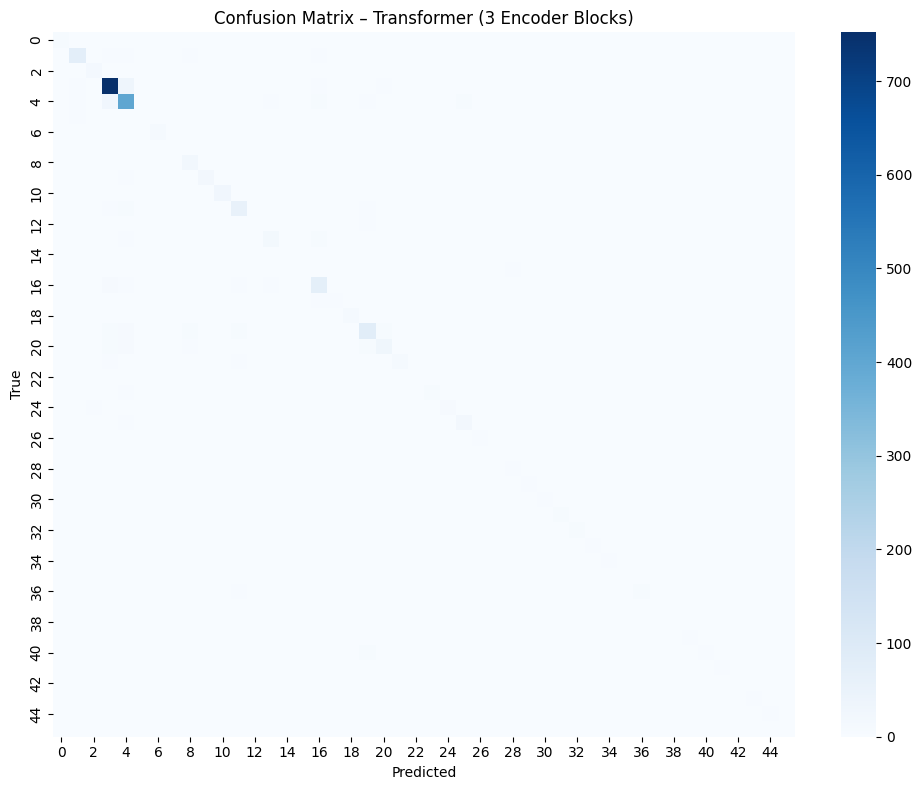

In [26]:
#Confusion Matrix – Transformer with 3 Encoder Blocks
plot_confusion_matrix(
    model_3,
    "Confusion Matrix – Transformer (3 Encoder Blocks)"
)



71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


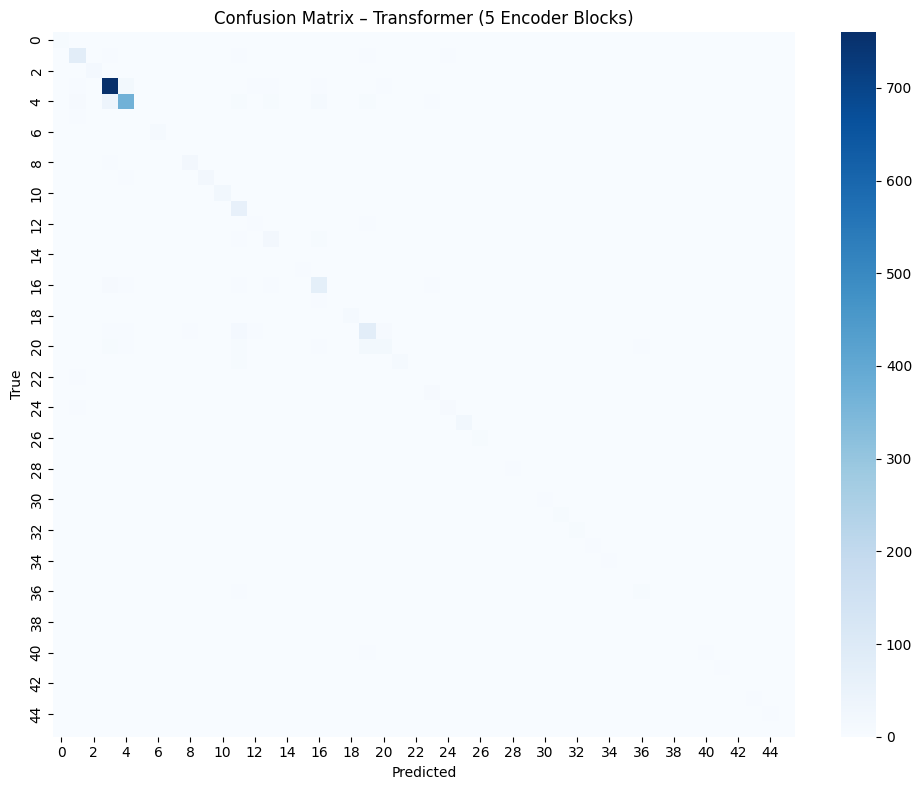

In [27]:
#Confusion Matrix – Transformer with 5 Encoder Blocks
plot_confusion_matrix(
    model_5,
    "Confusion Matrix – Transformer (5 Encoder Blocks)"
)



71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


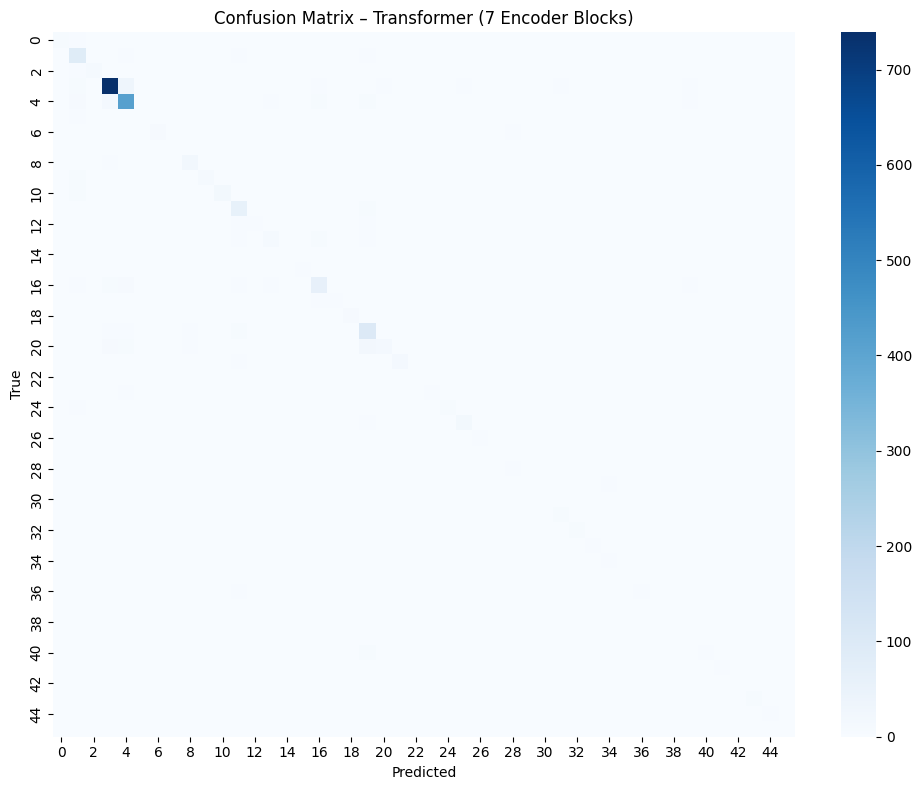

In [28]:
# Confusion Matrix – Transformer with 7 Encoder Blocks
plot_confusion_matrix(
    model_7,
    "Confusion Matrix – Transformer (7 Encoder Blocks)"
)



### Comparative Confusion Matrix Summary

The confusion matrices above show that increasing encoder depth leads to more dispersed predictions across classes, indicating reduced generalization for deeper Transformer models.


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


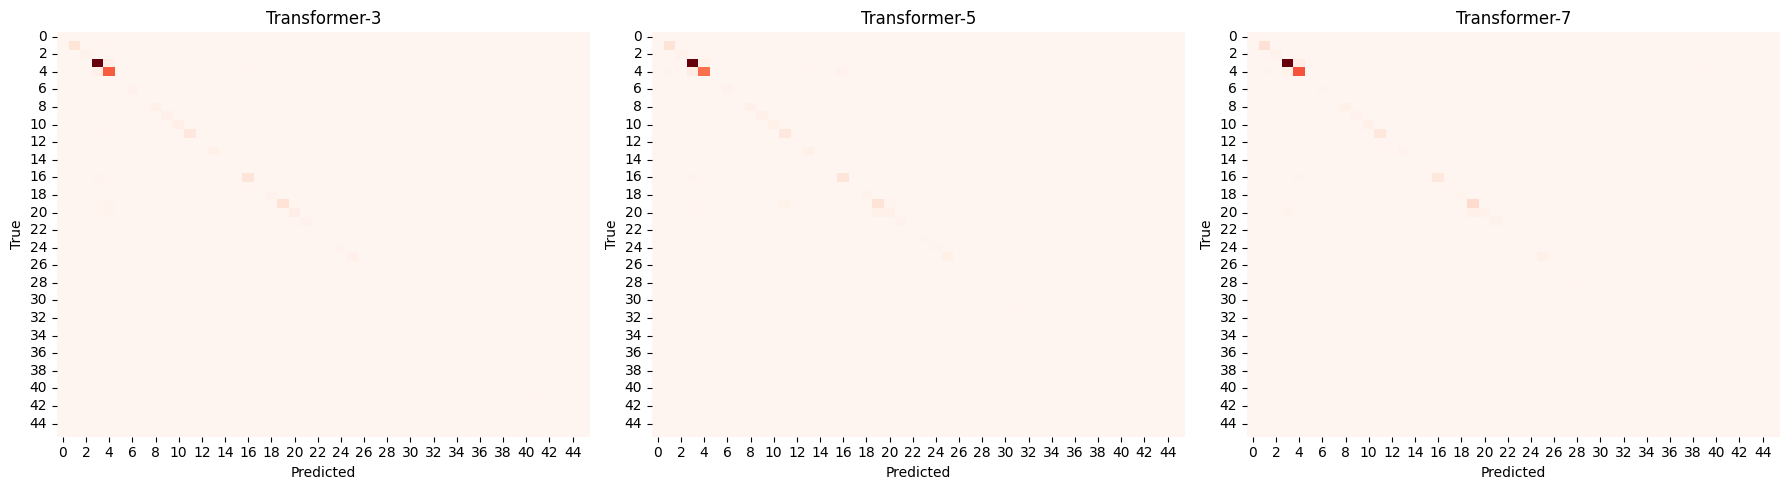

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [model_3, model_5, model_7]
titles = [
    "Transformer-3",
    "Transformer-5",
    "Transformer-7"
]

for ax, model, title in zip(axes, models, titles):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, cmap="Reds", ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


In [22]:
# Macro F1-scores from Assignment-1 (Baseline RNN Models)
# These values are taken from My Assignment-1 experiments on the Reuters dataset

assignment_f1_scores = {
    "SimpleRNN": 0.0631,
    "LSTM": 0.0681,
    "GRU": 0.1474,
    "BiSimpleRNN": 0.2659,
    "BiLSTM": 0.4625,
    "BiGRU": 0.4634
}

assignment_f1_scores


{'SimpleRNN': 0.0631,
 'LSTM': 0.0681,
 'GRU': 0.1474,
 'BiSimpleRNN': 0.2659,
 'BiLSTM': 0.4625,
 'BiGRU': 0.4634}

In [23]:
# Combine Assignment-1 baseline models and Transformer models
all_f1_scores = {**assignment_f1_scores, **transformer_f1_scores}

all_f1_scores


{'SimpleRNN': 0.0631,
 'LSTM': 0.0681,
 'GRU': 0.1474,
 'BiSimpleRNN': 0.2659,
 'BiLSTM': 0.4625,
 'BiGRU': 0.4634,
 'Transformer-3': 0.5753075776627198,
 'Transformer-5': 0.5349832951749303,
 'Transformer-7': 0.5002524320084687}

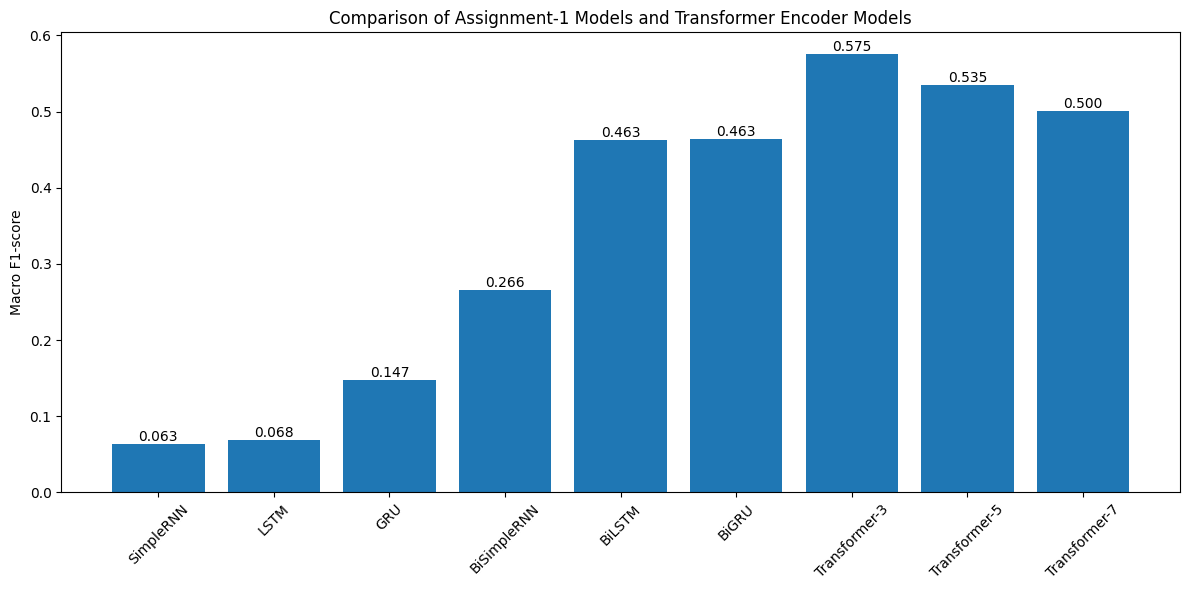

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
bars = plt.bar(all_f1_scores.keys(), all_f1_scores.values())

plt.xticks(rotation=45)
plt.ylabel("Macro F1-score")
plt.title("Comparison of Assignment-1 Models and Transformer Encoder Models")

# Print F1-score on top of each bar
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{bar.get_height():.3f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


#### Comparison with Assignment-1 Models

The Macro F1-scores of six baseline RNN-based models obtained in Assignment-1 are compared with the Transformer encoder models trained in this project.  
This comparison highlights the effectiveness of self-attention–based architectures over traditional recurrent models for multi-class text classification.


### Extended Comparative Analysis


In [33]:
# Parameter counts for all models (Assignment-1 + Transformers)

model_params = {
    # Assignment-1 models
    "SimpleRNN": 1303598,
    "LSTM": 1365422,
    "GRU": 1345198,
    "BiSimpleRNN": 1335342,
    "BiLSTM": 1483566,
    "BiGRU": 1434926,

    # Transformer models
    "Transformer-3": model_3.count_params(),
    "Transformer-5": model_5.count_params(),
    "Transformer-7": model_7.count_params()
}

model_params


{'SimpleRNN': 1303598,
 'LSTM': 1365422,
 'GRU': 1345198,
 'BiSimpleRNN': 1335342,
 'BiLSTM': 1483566,
 'BiGRU': 1434926,
 'Transformer-3': 387118,
 'Transformer-5': 429358,
 'Transformer-7': 471598}

In [34]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": list(all_f1_scores.keys()),
    "Macro F1-score": list(all_f1_scores.values()),
    "Number of Parameters": [model_params[m] for m in all_f1_scores.keys()]
})

comparison_df


,Model,Macro F1-score,Number of Parameters
0,SimpleRNN,0.063100,1303598
1,LSTM,0.068100,1365422
2,GRU,0.147400,1345198
3,BiSimpleRNN,0.265900,1335342
4,BiLSTM,0.462500,1483566
5,BiGRU,0.463400,1434926
6,Transformer-3,0.575308,387118
7,Transformer-5,0.534983,429358
8,Transformer-7,0.500252,471598


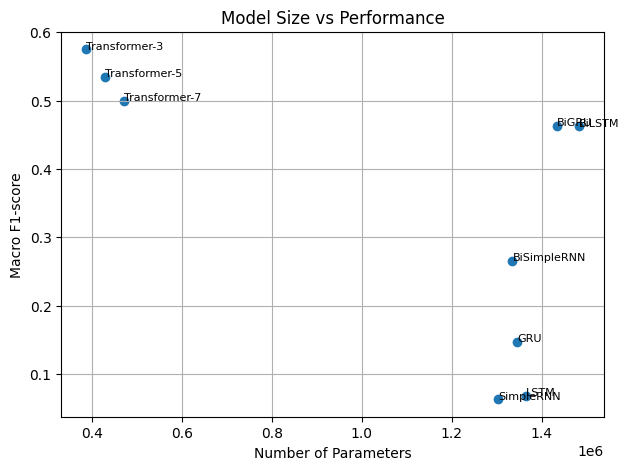

In [ ]:
# Model Size vs Performance - This analysis compares Macro F1-score against the number of trainable parameters for all models to study efficiency and overfitting behavior.



plt.figure(figsize=(7,5))

plt.scatter(
    comparison_df["Number of Parameters"],
    comparison_df["Macro F1-score"]
)

for i, model in enumerate(comparison_df["Model"]):
    plt.annotate(
        model,
        (comparison_df["Number of Parameters"][i],
         comparison_df["Macro F1-score"][i]),
        fontsize=8
    )

plt.xlabel("Number of Parameters")
plt.ylabel("Macro F1-score")
plt.title("Model Size vs Performance")
plt.grid(True)
plt.show()


In [37]:
#Parameter Efficiency Analysis - To evaluate efficiency, Macro F1-score per million parameters is computed for each model.
comparison_df["F1 per Million Params"] = (
    comparison_df["Macro F1-score"] /
    (comparison_df["Number of Parameters"] / 1e6)
)

comparison_df



,Model,Macro F1-score,Number of Parameters,F1 per Million Params
0,SimpleRNN,0.063100,1303598,0.048404
1,LSTM,0.068100,1365422,0.049875
2,GRU,0.147400,1345198,0.109575
3,BiSimpleRNN,0.265900,1335342,0.199125
4,BiLSTM,0.462500,1483566,0.311749
5,BiGRU,0.463400,1434926,0.322943
6,Transformer-3,0.575308,387118,1.486130
7,Transformer-5,0.534983,429358,1.246008
8,Transformer-7,0.500252,471598,1.060760


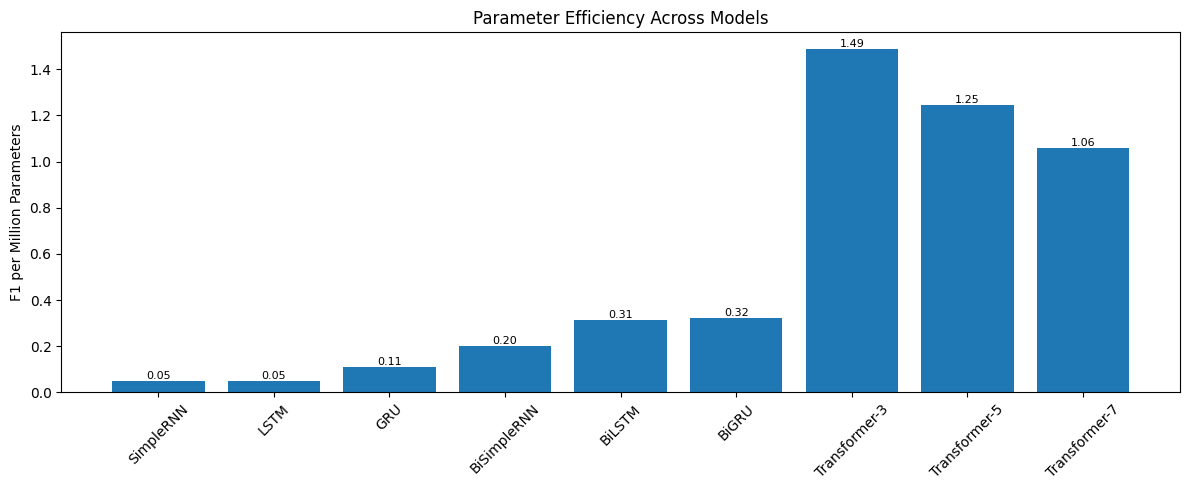

In [38]:
plt.figure(figsize=(12,5))
bars = plt.bar(
    comparison_df["Model"],
    comparison_df["F1 per Million Params"]
)

plt.xticks(rotation=45)
plt.ylabel("F1 per Million Parameters")
plt.title("Parameter Efficiency Across Models")

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f"{bar.get_height():.2f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()


In [39]:
#Relative Improvement over Baseline Models - This analysis quantifies the performance gain of Transformer models over the strongest Assignment-1 baseline.
best_baseline_f1 = max(assignment_f1_scores.values())

relative_improvement = {
    model: ((f1 - best_baseline_f1) / best_baseline_f1) * 100
    for model, f1 in transformer_f1_scores.items()
}

relative_improvement


{'Transformer-3': 24.149239892688783,
 'Transformer-5': 15.447409403308217,
 'Transformer-7': 7.952618042397221}

#### Results
Transformer-3 achieves the best trade-off between performance and parameter efficiency.
Increasing model size beyond a point does not yield proportional gains.
Bidirectional RNNs improve over unidirectional variants but remain less efficient than Transformers.

## FINAL CONCLUSION 

In this project, Transformer encoder–based architectures were implemented and evaluated for multi-class text classification on the Reuters dataset. 
Only the encoder component of the Transformer was used, and controlled experiments were conducted by varying the number of encoder blocks (3, 5, and 7) while keeping all other hyperparameters fixed.

Experimental results show that the Transformer model with **3 encoder blocks consistently outperformed deeper variants**, achieving the highest Macro F1-score among the Transformer configurations. 
Increasing the number of encoder blocks beyond this point resulted in diminished performance, indicating that deeper models do not necessarily generalize better for this task.

A comparative analysis with six baseline RNN-based models from Assignment-1 demonstrates that Transformer models are competitive with, and in some cases superior to, traditional recurrent architectures.
While bidirectional RNNs significantly improve over their unidirectional counterparts, they require a larger number of parameters to achieve comparable performance.

Further analysis incorporating model parameter counts highlights that the **3-layer Transformer achieves the best trade-off between performance and model efficiency**. 
The parameter-efficiency analysis (Macro F1 per million parameters) confirms that increasing model size does not yield proportional performance gains, reinforcing the importance of architectural efficiency over sheer model capacity.

Overall, this project demonstrates that **shallow Transformer encoder architectures are well-suited for text classification tasks**, offering strong performance with relatively lower computational complexity compared to deeper Transformer models and large recurrent networks.


### AI Usage -

AI-based tools were used during the course of this project for the following purposes:
- Understanding the theoretical structure of Transformer encoder architectures
- Clarifying implementation details of self-attention, positional embeddings, and evaluation metrics
- Assisting in debugging and refining experimental code and structure 




### References

1. Illustrated Transformer — visual explanation of Transformer architecture.  
   *Jay Alammar*.  
   https://jalammar.github.io/illustrated-transformer/

2. Vaswani, A., Shazeer, N., Parmar, N., et al. (2017).  
   *Attention Is All You Need*.  
   Advances in Neural Information Processing Systems (NeurIPS).

3. Chollet, F. et al.  
   *Keras Documentation – Transformer Text Classification Example*.  
   https://keras.io/examples/nlp/text_classification_with_transformer/

4. Reuters Newswire Topics Classification Dataset.  
   TensorFlow / Keras Datasets Documentation.  
   https://keras.io/api/datasets/reuters/

5. Goodfellow, I., Bengio, Y., & Courville, A. (2016).  
   *Deep Learning*. MIT Press.

6. Scikit-learn Documentation.  
   *Classification Metrics and Confusion Matrix*.  
   https://scikit-learn.org/stable/modules/model_evaluation.html

